In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .
!git clone https://github.com/fhvilshoj/TorchLRP.git

     |████████████████████████████████| 2.5MB 7.4MB/s 
     |████████████████████████████████| 901kB 51.3MB/s 
     |████████████████████████████████| 3.3MB 50.6MB/s 
Cloning into 'TorchLRP'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 306 (delta 36), reused 58 (delta 22), pack-reused 220
Receiving objects: 100% (306/306), 111.69 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [4]:
!cp TorchLRP/examples/utils.py .
!cp TorchLRP/examples/visualization.py .

In [ ]:
import pandas as pd
import numpy as np
import json, re, os
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.insert(1, '/content/TorchLRP')


## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# LRP
import lrp
from utils import get_mnist_model, prepare_mnist_model, get_mnist_data
from utils import store_patterns, load_patterns
from visualization import heatmap_grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive

# Encoding and Utils
%run utils_fake_news.py

# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

## Preprocess & Encode Data

In [53]:
# Load the Fake-News Kaggle dataset
df_train = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news_train.csv")
df_train = df_train.dropna(subset=['text'])
# df_neg = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Negation_Task/fake_news_negative.csv")

# Relabel target
df_train['target'] = df_train['label']
# df_neg['target'] = df_neg['label'].apply(lambda x: 0 if x==1 else 1)
# df_train = df_pos.append(df_neg).reset_index(drop=True)

# Encode dataframes using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train['text'])
vocab = vectorizer.get_feature_names()

# Convert to sparse PyTorch matrix
X = X.tocoo()
X = torch.sparse.FloatTensor(torch.LongTensor([X.row.tolist(), X.col.tolist()]),
                              torch.FloatTensor(X.data.astype(np.float)))

# Feed as TensorDataset
df_encode = TensorDataset(X, torch.LongTensor(df_train['target']))

## Model & Training Function

In [7]:
import torch.nn as nn
from transformers import AutoModel
# class FakeBERT(nn.Module):
#     def __init__(self, vocab_size):
#         super(FakeBERT, self).__init__()
        
#         # Layer 1: Conv1D + Maxpool
#         self.conv_1 = lrp.Linear(vocab_size, 153)
#         self.sigm_1 = nn.ReLU()
        
#         # Layer 6: Fully Connected Layer 
#         self.full_6 = lrp.Linear(153,32)
#         self.sigm_6 = nn.ReLU()
        
#         # Layer 7: Fully Connected Layer 
#         self.full_7 = lrp.Linear(32,2)

#     def forward(self, input): # input_ids, attn_mask):
#         outputs = self.sigm_1(self.conv_1(input))
#         outputs = self.sigm_6(self.full_6(outputs))
#         # outputs = self.soft_7(self.full_7(outputs))
#         outputs = self.full_7(outputs)
#         return outputs

def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):
            # Unpack batch
            b_input = batch[0].to(device)
            # b_input_mask = batch[1].to(device)
            b_labels = batch[1].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output = bert_model(b_input)
            
            # Accumulate loss
            loss = loss_func(output.squeeze(1), b_labels)
            
            # Backpropagate
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            # torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
                print(f'Loss: {loss.detach()}')
                
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                # 'Valid. Loss': avg_val_loss,
                # 'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                # 'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [8]:
# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
    df_encode,  # The training samples.
    batch_size = batch_size # Trains with this batch size.
    )

## Training

In [9]:
# Model
vocab_size = X.shape[1]
bert_model = lrp.Sequential(
                     lrp.Linear(vocab_size, 153),
                     torch.nn.ReLU(),
                     lrp.Linear(153,32),
                     torch.nn.ReLU(),
                     lrp.Linear(32,2)
                 ).to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-3, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Training Params
bert_training_stats = []
epochs = 2
total_steps = len(bert_train_dataloader) * epochs
loss_func = nn.CrossEntropyLoss()

# Learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps = 0, # Default value in run_glue.py
                                                 num_training_steps = total_steps)

In [11]:
# Train or load pre-trained
tfidf_model = "/content/drive/MyDrive/fake-news-explainability/Models/bert_model_tfidf"

if os.path.exists(tfidf_model):
    bert_model.load_state_dict(torch.load(tfidf_model))
else:
    train()
    torch.save(bert_model.state_dict(), tfidf_model)

## Evaluate

In [12]:
with torch.no_grad():
    outputs = bert_model.forward(X.to(device))
    print(f"Acc: {flat_accuracy(outputs.detach().cpu().numpy(), df_encode.tensors[1].to('cpu').numpy())}")

Acc: 0.9996146621068349


In [34]:
all_patterns_path = 'TorchLRP/examples/patterns/pattern_all.pkl'
if not os.path.exists(all_patterns_path):
    patterns_all = fit_patternnet(bert_model, bert_train_dataloader, device=device)
    store_patterns(all_patterns_path, patterns_all)
    !cp TorchLRP/examples/patterns/pattern_all.pkl drive/MyDrive/fake-news-explainability/TorchLRP-master/examples/patterns
else:
    patterns_all = [torch.tensor(p, device=args.device, dtype=torch.float32) for p in load_patterns(all_patterns_path)]

100%|██████████| 163/163 [07:21<00:00,  2.71s/it]


In [13]:
# Collect sample data
X_test = torch.vstack([X[i].to_dense() for i in range(5)]).requires_grad_(True)
X_test.grad = None

# Make prediction
y_hat = bert_model.forward(X_test.to(device), explain=True, rule="alpha2beta1")
y_hat = y_hat[range(X_test.shape[0]), y_hat.max(1)[1]] # Choose maximizing output neuron
y_hat = y_hat.sum()

# Backward pass (do explanation)
y_hat.backward()
explanation = X_test.grad
explanation

tensor([[-0., 0., -0.,  ..., 0., -0., 0.],
        [0., -0., 0.,  ..., -0., 0., -0.],
        [-0., 0., 0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., -0., 0.]])

In [14]:
# Get the vocab with the top 10 highest explanation scores (by magnitude)
explanation_idx = torch.topk(torch.abs(explanation), k=10, dim=1).indices
explanation_val = torch.vstack([explanation[i][explanation_idx[i]] for i in range(5)])
explanation_key = [[vocab[idx] for idx in explanation_idx[i]] for i in range(5)]

In [44]:
def as_pyplot_figure(vals, names, label=1, **kwargs):
    """Returns the explanation as a pyplot figure.
    Will throw an error if you don't have matplotlib installed
    Args:
        label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
        kwargs: keyword arguments, passed to domain_mapper
    Returns:
        pyplot figure (barchart).
    """
    import matplotlib.pyplot as plt
    vals, names = vals[::-1], names[::-1]
    fig = plt.figure()
    colors = ['orange' if x > 0 else 'blue' for x in vals]
    pos = np.arange(len(vals)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    title = 'Local explanation'
    plt.title(title)

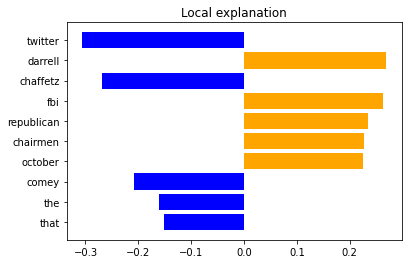

In [45]:
as_pyplot_figure(vals = explanation_val[0].tolist(),
                 names = explanation_key[0])

## Negation

In [54]:
# Load the Fake-News Kaggle dataset
df_pos = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Negation_Task/fake_news_positive.csv", nrows=5)
df_neg = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Negation_Task/fake_news_negative.csv", nrows=5)

# Relabel target
df_pos['target'], df_neg['target'] = df_pos['label'], df_neg['label']

# Encode dataframes using TF-IDF
X_pos = vectorizer.transform(df_pos['text'])
X_neg = vectorizer.transform(df_neg['text'])
X_pos, X_neg = X_pos.todense(), X_neg.todense()

# To PyTorch
X_pos, X_neg = torch.Tensor(X_pos), torch.Tensor(X_neg)

In [ ]:
# Format sample data from positive class
X_pos = X_pos.requires_grad_(True)
X_pos.grad = None

# Make prediction
y_hat = bert_model.forward(X_pos.to(device), explain=True, rule="alpha2beta1")
y_hat = y_hat[range(X_pos.shape[0]), y_hat.max(1)[1]] # Choose maximizing output neuron
y_hat = y_hat.sum()

# Backward pass (do explanation)
y_hat.backward()
explanation_pos = X_pos.grad

In [63]:
# Format sample data from negative class
X_neg = X_neg.requires_grad_(True)
X_neg.grad = None

# Make prediction
y_hat = bert_model.forward(X_neg.to(device), explain=True, rule="alpha2beta1")
y_hat = y_hat[range(X_neg.shape[0]), y_hat.max(1)[1]] # Choose maximizing output neuron
y_hat = y_hat.sum()

# Backward pass (do explanation)
y_hat.backward()
explanation_neg = X_neg.grad

tensor([[-0., 0., -0.,  ..., 0., -0., 0.],
        [0., -0., 0.,  ..., -0., 0., -0.],
        [-0., 0., 0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., -0., 0.]])

In [80]:
def append_not(t):
  return torch.cat((t, torch.tensor([vocab.index('not')])))
  
# Get the vocab with the top 10 highest explanation scores (by magnitude)
explanation_idx_pos = torch.topk(torch.abs(explanation_pos), k=10, dim=1).indices
explanation_idx_pos = torch.vstack([append_not(explanation_idx_pos[i]) for i in range(5)])
explanation_val_pos = torch.vstack([explanation_pos[i][explanation_idx_pos[i]] for i in range(5)])
explanation_key_pos = [[vocab[idx] for idx in explanation_idx_pos[i]] for i in range(5)]

# Get the vocab with the top 10 highest explanation scores (by magnitude)
explanation_idx_neg = torch.topk(torch.abs(explanation_neg), k=10, dim=1).indices
explanation_idx_neg = torch.vstack([append_not(explanation_idx_neg[i]) for i in range(5)])
explanation_val_neg = torch.vstack([explanation_neg[i][explanation_idx_neg[i]] for i in range(5)])
explanation_key_neg = [[vocab[idx] for idx in explanation_idx_neg[i]] for i in range(5)]

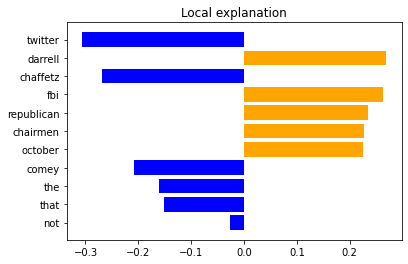

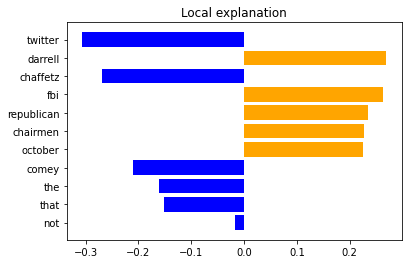

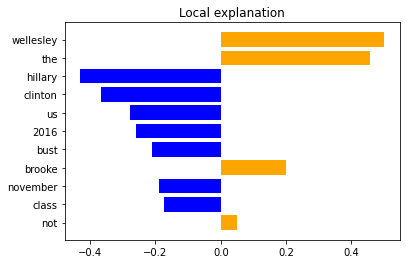

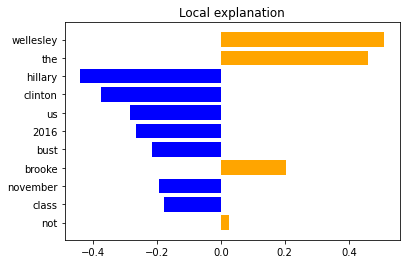

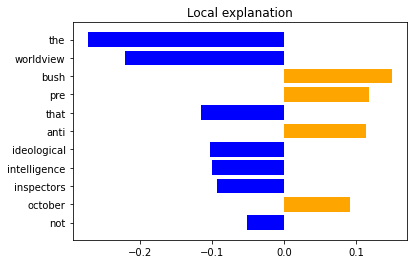

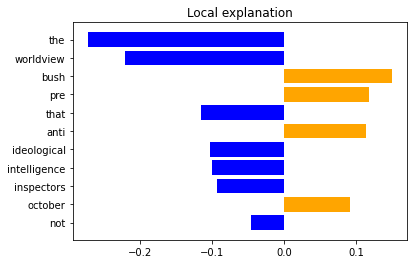

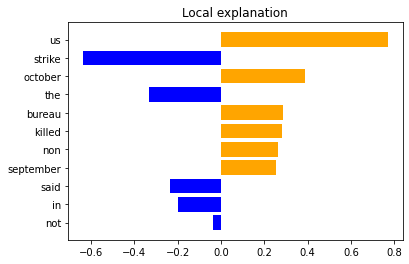

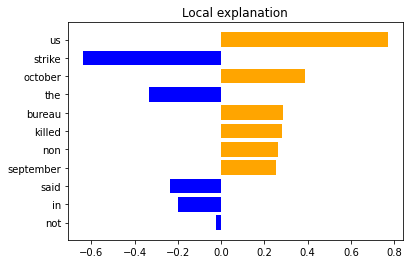

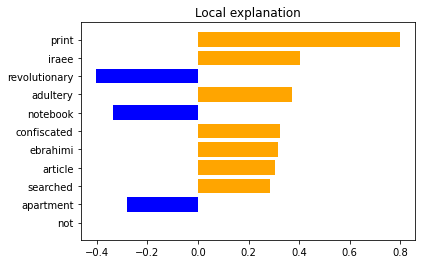

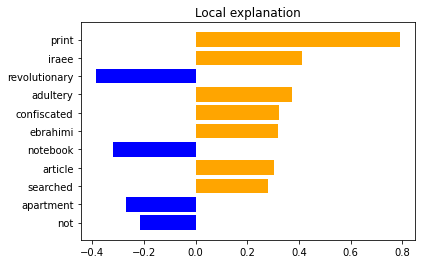

In [82]:
for i in range(5):
    as_pyplot_figure(vals = explanation_val_pos[i].tolist(),
                    names = explanation_key_pos[i])
    as_pyplot_figure(vals = explanation_val_neg[i].tolist(),
                    names = explanation_key_neg[i])